## 1. Library

In [11]:
import json

import pandas as pd
from matplotlib import pyplot as plt

from tqdm import tqdm
from transformers import AutoTokenizer

from koeda import EDA

## 2. Load

In [2]:
train_path = './data/train.csv'
dev_path = './data/dev.csv'

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(dev_path)

val_data.head(5)


,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-dev-000,nsmc-sampled,액션은개뿔 총몇번쏘고 끝입니다,액션은 흉내만 내고 그마저도 후반부에는 슬로우모션 처리,2.0,0.0
1,boostcamp-sts-v1-dev-001,slack-rtt,감격스러워 입막으심?,너무 감동해서 입 다물어?,3.4,1.0
2,boostcamp-sts-v1-dev-002,nsmc-rtt,이번 년도에 본 영화 중 가장 최악의 영화......,올해 본 영화 중 최악...,4.0,1.0
3,boostcamp-sts-v1-dev-003,slack-rtt,특히 평소 뮤직채널에 많은 영감을 불어넣어주시는!,"특히, 당신은 항상 많은 음악 채널에 영감을 줍니다!",3.4,1.0
4,boostcamp-sts-v1-dev-004,slack-sampled,다음 밥스테이지가 기대됩니다~ ㅎ,다음 후기도 기대됩니다~~,1.4,0.0


## 3. EDA
1. 소스별 데이터 개수
2. 소스별 바이너리 라벨 분포 (0/1 개수)
3. 소스별 라벨 분포(0,1,2,3,4,5 개수)

In [3]:
train_data['source'].unique()

array(['nsmc-sampled', 'slack-rtt', 'petition-sampled', 'slack-sampled',
       'nsmc-rtt', 'petition-rtt'], dtype=object)

In [4]:
train_data[train_data['source']=='nsmc-rtt'].count()

id              788
source          788
sentence_1      788
sentence_2      788
label           788
binary-label    788
dtype: int64

In [5]:
train_data.isnull().values.any()

False

In [6]:
train_data[train_data['source']=='nsmc-rtt'].head(5)

,id,source,sentence_1,sentence_2,label,binary-label
5,boostcamp-sts-v1-train-005,nsmc-rtt,오마이가뜨지져스크롸이스트휏,오 마이 갓 지저스 스크론 이스트 팬,2.6,1.0
12,boostcamp-sts-v1-train-012,nsmc-rtt,오랫만에 존쿠삭의 연기보니 좋네요 Good~~!!,오랜만에 존 쿠삭의 연기를 보니 반갑다. 좋아요~~!!,3.8,1.0
24,boostcamp-sts-v1-train-024,nsmc-rtt,군대가기전에 봤었는데 진짜 윈터스같은 사람이 상관이면 목숨걸고 싸워도 후회는 없지 ...,입대하기 전에 봤는데 윈터스 같은 사람이 진심으로 아껴준다면 목숨을 걸고 싸워도 후...,4.2,1.0
29,boostcamp-sts-v1-train-029,nsmc-rtt,한사람의 파멸을 적나라하게 드러내 준 영화,한 사람의 파멸을 드러내는 영화,3.6,1.0
34,boostcamp-sts-v1-train-034,nsmc-rtt,전설따라 삼천리(삼만리인가?)에 의하면 이 영화가 꽤 괜찮다고 할뿐 아니라 내가 좋...,전설에 따르면 삼천리(삼천리?)에 따르면 이 영화는 꽤 괜찮을 뿐만 아니라 내가 제...,4.0,1.0


In [7]:
train_data['source'].value_counts()

petition-sampled    2352
nsmc-sampled        2296
slack-sampled       2024
slack-rtt           1047
petition-rtt         817
nsmc-rtt             788
Name: source, dtype: int64

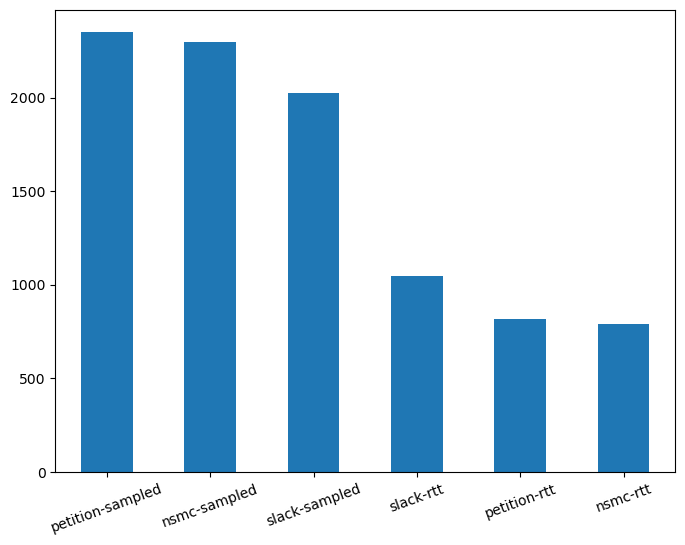

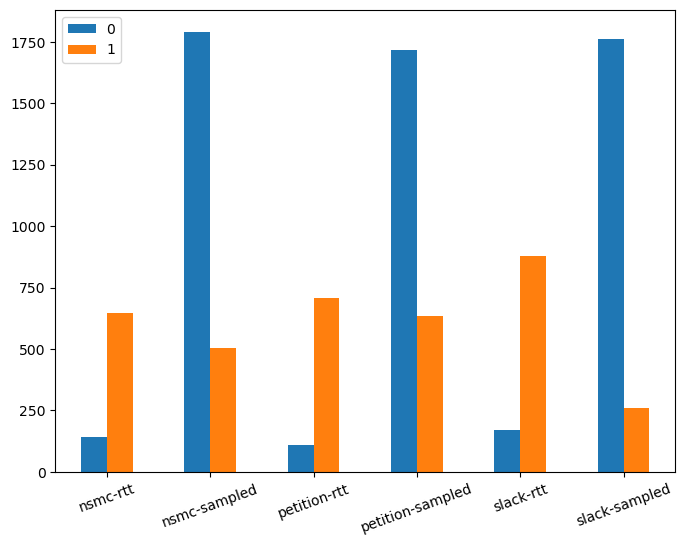

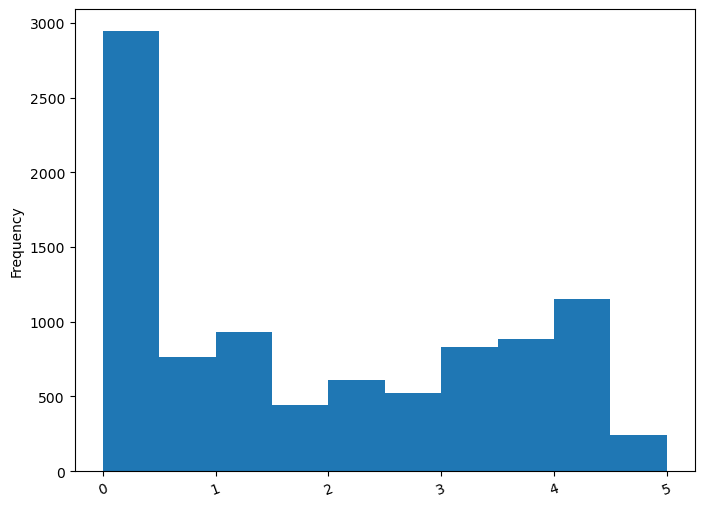

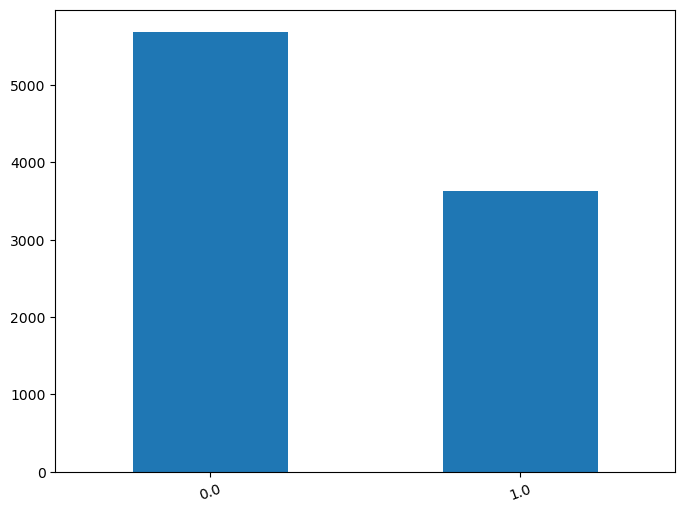

In [190]:
def draw_graph(df):
    source_binary = {source:[0, 0] for source in sorted(df['source'].unique())}
    for i, item in df.iterrows():
        source_binary[item['source']][int(item['binary-label'])] += 1
    source_binary_df = pd.DataFrame(source_binary).transpose()

    # source의 분포
    df['source'].value_counts().plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()
    # source별 binary label의 분포
    source_binary_df.plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()
    # label의 분포
    df['label'].plot(kind='hist', rot=20, figsize=(8, 6))
    plt.show()
    # binary label의 분포
    df['binary-label'].value_counts().plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()
    
    
draw_graph(train_data)

In [8]:
# 나는 이제 라벨별 0-5 단계로 나뉘어서 개수를 확인하고 싶다.

source_binary = {source:[0, 0] for source in sorted(train_data['source'].unique())}
for i, item in train_data.iterrows():
    source_binary[item['source']][int(item['binary-label'])] += 1
source_binary_df = pd.DataFrame(source_binary).transpose()

source_binary
#source_binary_df.transpose()
# # source별 binary label의 분포
# source_binary_df.plot(kind='bar', rot=20, figsize=(8, 6))
# plt.show()



{'nsmc-rtt': [141, 647],
 'nsmc-sampled': [1791, 505],
 'petition-rtt': [110, 707],
 'petition-sampled': [1719, 633],
 'slack-rtt': [169, 878],
 'slack-sampled': [1762, 262]}

<Axes: >

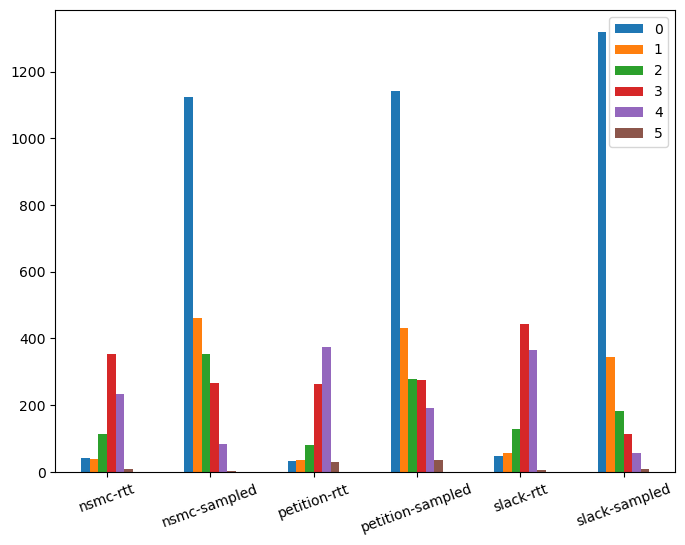

In [9]:
# 0~5 단계별 나누기

# unique개수만큼 행, 0~5 단게별 열
source_label = {source:[0, 0, 0, 0, 0, 0] for source in sorted(train_data['source'].unique())}  

for i, item in train_data.iterrows():
    label_value = int(item['label'])
    if   label_value == 0:  col = 0
    elif label_value < 2.0: col = 1
    elif label_value < 3.0: col = 2
    elif label_value < 4.0: col = 3
    elif label_value < 5.0: col = 4
    else:                   col = 5
        
    source_label[item['source']][col] += 1

source_label_df = pd.DataFrame(source_label).transpose()
source_label_df.plot(kind='bar', rot=20, figsize=(8, 6))

In [12]:
# nsmc-sampled 에 대해서, 점수대별 토큰 길이 확인해보기
# x 축 label, y축 토큰 길이
# 라벨 2.0-2.9: 토큰 개수 5 n개 6 N개 ... 
# source token_number_1 label


tokenizer = AutoTokenizer.from_pretrained('klue/roberta-small')


In [13]:
## 히스토그램 FOR 소스 문장 길이
import seaborn as sns

tokenizer = AutoTokenizer.from_pretrained('klue/roberta-small')

def tokenizing(df):
    sentence1_len, sentence2_len = [], []
    sentence1_unk, sentence2_unk = [], []
    
    for i, item in df.iterrows():
        sentence1 = tokenizer(item['sentence_1'])['input_ids']
        sentence2 = tokenizer(item['sentence_2'])['input_ids']

        sentence1_len.append(len(sentence1))
        sentence2_len.append(len(sentence2))

        sentence1_unk.append(sentence1.count(tokenizer.unk_token_id))
        sentence2_unk.append(sentence2.count(tokenizer.unk_token_id))

    #tokenized_df = pd.DataFrame([sentence1_len, sentence2_len, sentence1_unk, sentence2_unk]).transpose()
    #tokenized_df.columns = ['1_len', '2_len', '1_unk', '2_unk']

    #return tokenized_df
    return pd.DataFrame({'number of tokens':sentence1_len, 'label score':df.label.values.tolist()})

# def draw_graph(pd):
#     # 각 분포도 확인하고, 서로의 Joint 상관관계도 확인

#     #ax = fig.add_subplot(111, aspect=2.5)
    
#     ax = sns.jointplot(x=sentence1_token_len_list, y=label_list)
#     ax.set_title
#     ax.set_axis_labels("number of tokens", "label score")
#     ax.figure.tight_layout()
#     plt.show()
    

nsmc_sampled_pd = train_data[train_data['source']=='nsmc-sampled']

# label - x축
label_list = nsmc_sampled_pd['label'].values.tolist()
# token 개수 - y축
sentence1_token_len_list = tokenizing(nsmc_sampled_pd)

In [14]:
sentence1_token_len_list

,number of tokens,label score
0,23,2.2
1,13,0.6
2,13,3.8
3,18,1.8
4,20,0.0
...,...,...
2291,10,1.6
2292,3,1.4
2293,8,3.4
2294,15,3.6


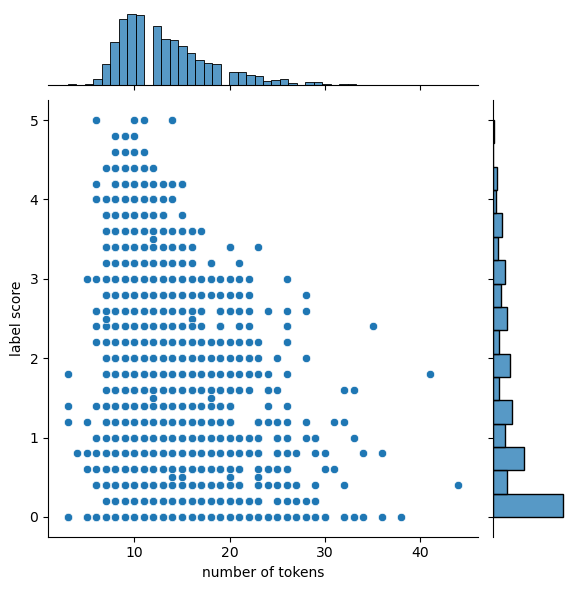

In [10]:
xaxis = sentence1_token_len_list.columns[0]
yaxis = sentence1_token_len_list.columns[1]

sns.jointplot(x=sentence1_token_len_list['number of tokens'], y=sentence1_token_len_list['label score'], data=sentence1_token_len_list)

In [86]:
print(s1_x, "\n", s1_y, "\n",  u1_x, "\n",  u1_y)
print(list(s1_x))

dict_keys([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 44]) 
 dict_values([2, 1, 4, 9, 28, 55, 92, 115, 122, 84, 84, 92, 74, 62, 51, 46, 39, 21, 33, 20, 19, 10, 12, 12, 7, 5, 10, 4, 1, 3, 2, 2, 2, 1, 1]) 
 odict_keys([0, 1, 2, 3, 4]) 
 odict_values([1077, 44, 1, 2, 1])
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 44]


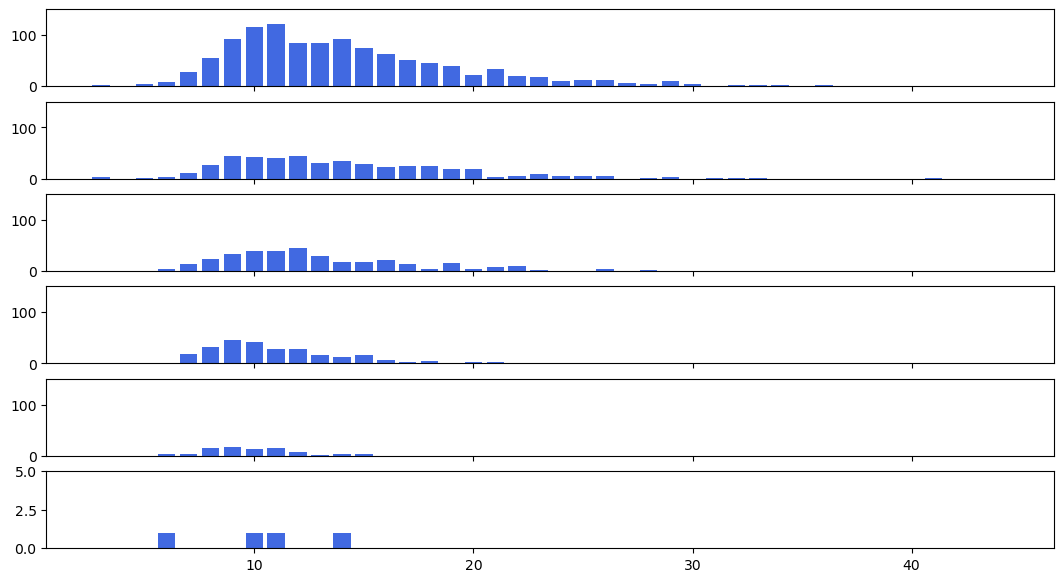

In [93]:
## source, score별로 나누어서 토큰 개수 확인해보기 

# settings
from collections import Counter, OrderedDict

tokenizer = AutoTokenizer.from_pretrained('klue/roberta-small')

def get_num_tokens(df):
    sentence1_len, sentence2_len = [], []
    sentence1_unk, sentence2_unk = [], []
    
    for i, item in df.iterrows():
        sentence1 = tokenizer(item['sentence_1'])['input_ids']
        sentence2 = tokenizer(item['sentence_2'])['input_ids']

        sentence1_len.append(len(sentence1))
        sentence2_len.append(len(sentence2))

        sentence1_unk.append(sentence1.count(tokenizer.unk_token_id))
        sentence2_unk.append(sentence2.count(tokenizer.unk_token_id))

    return sentence1_len, sentence2_len, sentence1_unk, sentence2_unk
    # return pd.DataFrame({'number of tokens':sentence1_len, 'label score':df.label.values.tolist()})

    
# 1. 전체 df에 대해 score 5단계로 분류, 열 추가
train_data_scored = train_data.copy(deep=True)
new_col = []

for i, item in train_data_scored.iterrows():
    label_value = int(item['label'])
    if   label_value == 0:  col = 0
    elif label_value < 2.0: col = 1
    elif label_value < 3.0: col = 2
    elif label_value < 4.0: col = 3
    elif label_value < 5.0: col = 4
    else:                   col = 5
        
    new_col.append(col)
train_data_scored['score_class'] = new_col

# 2. sentence 별 토큰 개수 넣기
s1_len, s2_len, s1_unk, s2_unk = get_num_tokens(train_data_scored)

train_data_scored['s1_num_tokens'] = s1_len
train_data_scored['s2_num_tokens'] = s2_len
train_data_scored['s1_num_unk'] = s1_unk
train_data_scored['s2_num_unk'] = s2_unk


# 3. source 별로 그룹화 - test for nsmc
grouped_df = train_data_scored.groupby(['source'])
grouped_df = grouped_df.get_group('nsmc-sampled').groupby(['score_class'])

score_list_unique = sorted(list(set(new_col)))

# 3-1. axis setting. x=토큰개수, y=해당 개수
x_axis, y_axis = [], []
fig, axes = plt.subplots(6, 1, figsize=(13, 7), sharex=True)


# 3-1. score 0~5 별로 그룹핑
for score in score_list_unique:
    s1_x, s1_y, s2_x, s2_y = [], [], [], []
    u1_x, u1_y, u2_x, u2_y = [], [], [], []
    grouped_df_scored = grouped_df.get_group(score).copy(deep=True)
    
    s1_counted   = OrderedDict(Counter(sorted(grouped_df_scored['s1_num_tokens'].values.tolist())))
    s2_counted   = OrderedDict(Counter(sorted(grouped_df_scored['s2_num_tokens'].values.tolist())))
    unk1_counted = OrderedDict(Counter(sorted(grouped_df_scored['s1_num_unk'].values.tolist())))
    unk2_counted = OrderedDict(Counter(sorted(grouped_df_scored['s2_num_unk'].values.tolist())))
    
    s1_x, s1_y = s1_counted.keys(),   s1_counted.values()
    s2_x, s2_y = s2_counted.keys(),   s2_counted.values()
    u1_x, u1_y = unk1_counted.keys(), unk1_counted.values()
    u2_x, u2_y = unk2_counted.keys(), unk2_counted.values()
    
    axes[score].bar(s1_x, s1_y, color='royalblue')
    #axes[score].bar(u1_x, list(u1_y), bottom=list(s1_y), color='tomato')
    
    axes[score].set_ylim(0, 150)

axes[5].set_ylim(0, 5)
plt.show()


In [15]:
## source, score별로 나누어서 토큰 개수 확인해보기 -> 위에서 막대그래프 그렸던, source_label_df 이거 가지고 해야한다. score가 분류되어있어야 함.

# source: nsmc-sampled
# score: 4
# xaxis = number of tokens
# yaxis = number of sentence each number of tokens

nsmc_sampled_pd = train_data[source_label_df['source']=='nsmc-sampled']
nsmc_sampled_tokens_and_scores = tokenizing(nsmc_sampled_pd)

In [79]:
x_axis

odict_keys([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 33])

odict_items([(6, 2), (7, 1), (8, 8), (9, 12), (10, 12), (11, 9), (12, 10), (13, 6), (14, 12), (15, 6), (16, 6), (17, 6), (18, 4), (19, 4), (20, 7), (21, 1), (22, 2), (23, 2), (25, 2), (26, 2), (28, 1), (29, 3), (33, 1)])


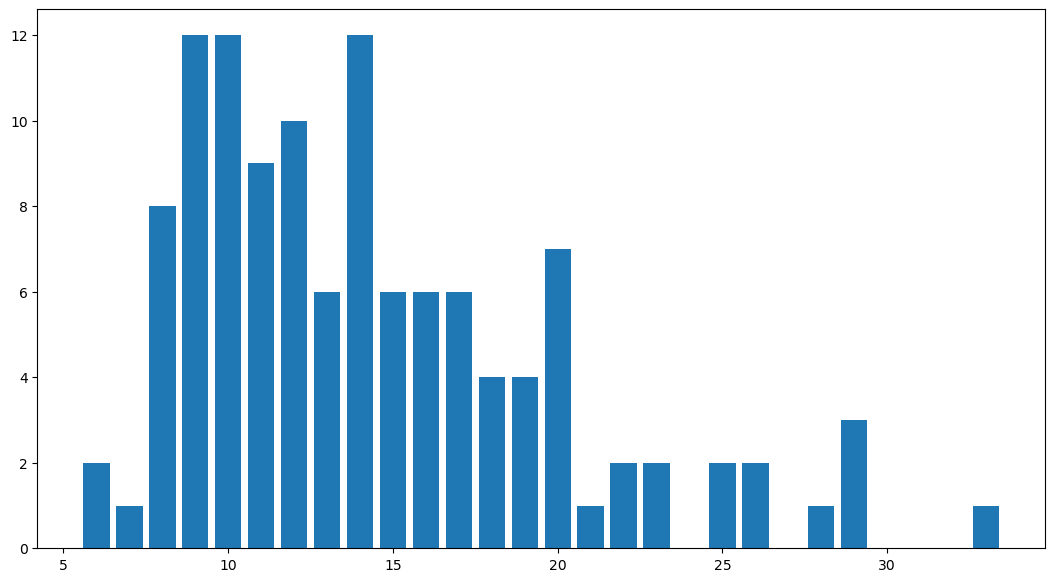

In [78]:
grouped_nsmc_sampled = nsmc_sampled_tokens_and_scores.groupby(["label score"])

# for i in range(
score_1 = grouped_nsmc_sampled.get_group(1).copy(deep=True)
score_1 = score_1.reset_index().drop(['index'], axis=1)

score_1_nt = sorted(score_1['number of tokens'].values.tolist())

from collections import Counter, OrderedDict
score_1_nt_count = OrderedDict(Counter(score_1_nt)) # num_of_tokens, count
print(score_1_nt_count.items())
x_axis = score_1_nt_count.keys()
y_axis = score_1_nt_count.values()



fig, ax = plt.subplots(1, 1, figsize=(13, 7))

ax.bar(x_axis, y_axis)

plt.show()

# score_1.plot(kind='bar', rot=40, figsize=(12,12))

In [48]:
y_axis

odict_values([2, 1, 8, 12, 12, 9, 10, 6, 12, 6, 6, 6, 4, 4, 7, 1, 2, 2, 2, 2, 1, 3, 1])

In [18]:
score_1.columns

NameError: name 'score_1' is not defined

<Axes: >

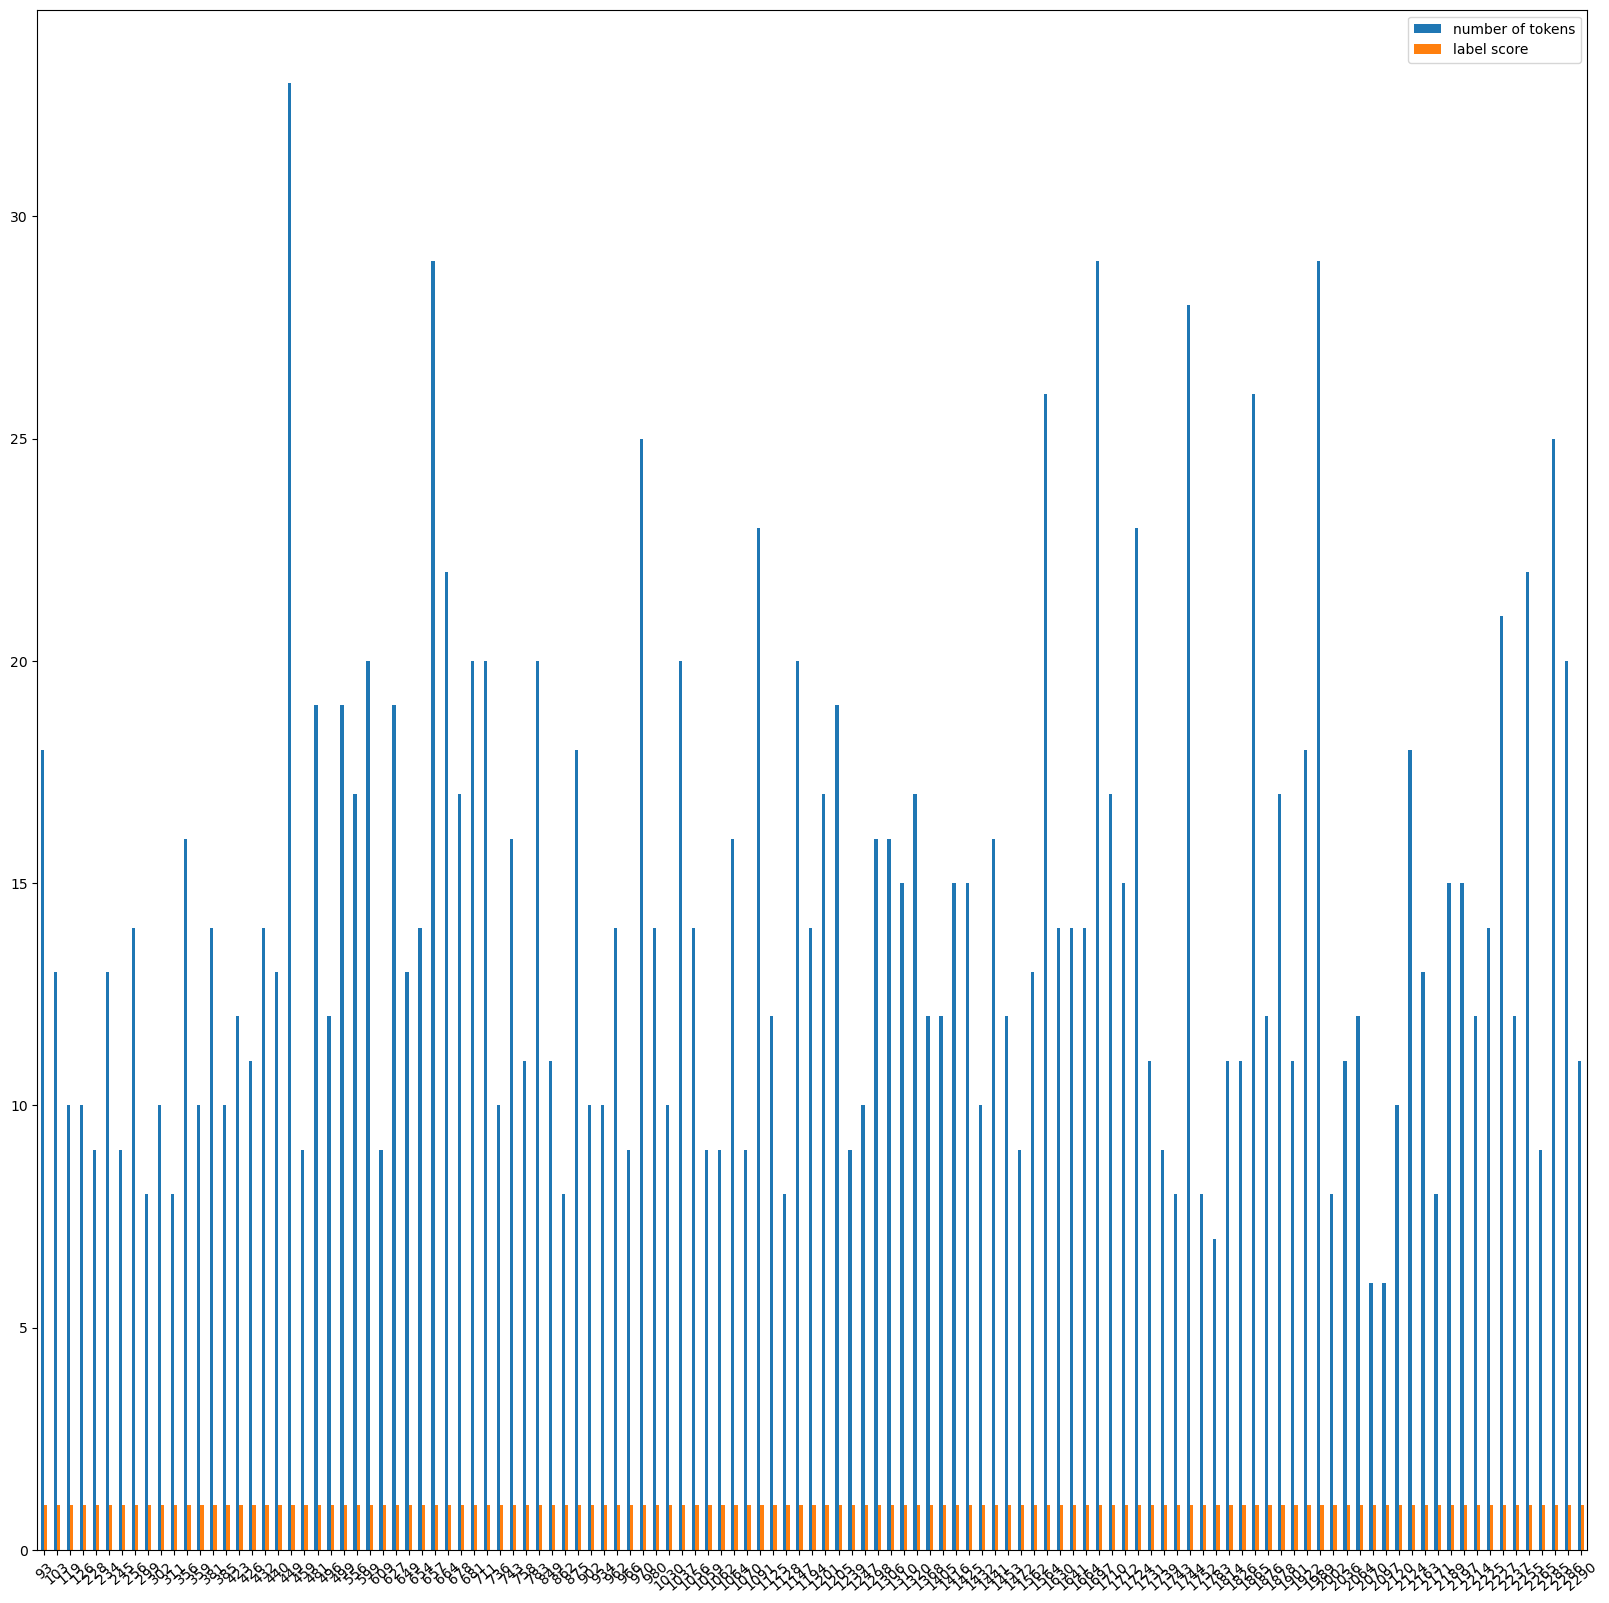

In [17]:

# grouped.get_group(1).sort_index().plot(kind='bar', rot=40, figsize=(20,20))

# source_label_df.plot(kind='bar', rot=20, figsize=(8, 6))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


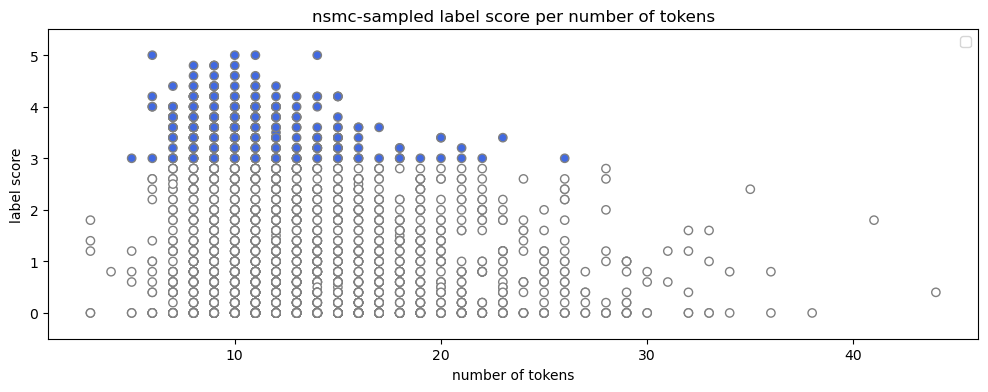

In [29]:



fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, aspect=2.5)
ax.set_ylim(-0.5, 5.5)


ax.scatter(y=label_list, x=sentence1_token_len_list,
           c=['white' if label<3.0 else 'royalblue' for label in label_list],
           marker='o',
           linewidth=1,
           edgecolor='gray')

ax.set_xlabel("number of tokens")
ax.set_ylabel("label score")
ax.set_title("nsmc-sampled label score per number of tokens")

# ax.legend()
plt.show()

AttributeError: 'JointGrid' object has no attribute 'set_title'

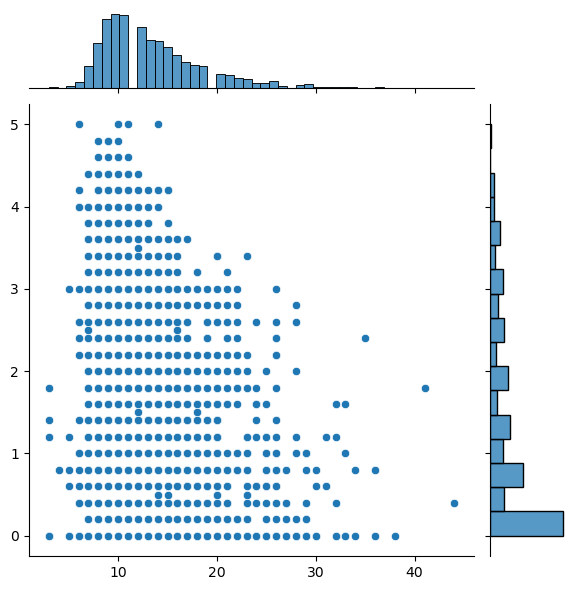

In [40]:
# 각 분포도 확인하고, 서로의 Joint 상관관계도 확인
import seaborn as sns
ax = fig.add_subplot(111, aspect=2.5)

ax = sns.jointplot(x=sentence1_token_len_list, y=label_list)
ax.set_title("haha")
ax.set_axis_labels("number of tokens", "label score")
ax.figure.tight_layout()
plt.show()

In [193]:
# 
# nsmc-rtt에 대해서는 1,2,5 데이터를,
# nsmc-sampled에 대해서는 0을 줄이고 4,5 데이터를,
# petition-rtt에 대해서는 1,2,5를
# slack-rtt에 대해서는 1,2,5를,
# slack-sampled에 대해서는 0을 줄이고 2,3,4,5를.

# 2nd 치의 80% 정도로는 맞춰보자.

source_label

{'nsmc-rtt': [43, 38, 114, 353, 232, 8],
 'nsmc-sampled': [1125, 462, 354, 266, 85, 4],
 'petition-rtt': [33, 37, 80, 263, 374, 30],
 'petition-sampled': [1142, 431, 278, 275, 191, 35],
 'slack-rtt': [49, 57, 128, 444, 364, 5],
 'slack-sampled': [1319, 343, 183, 114, 56, 9]}

In [ ]:
tokenized_df = tokenizing(train_data)


## 4. 데이터 증강 시도

In [194]:
# 증강을 위한 summarization
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("digit82/kobart-summarization")
# model = AutoModelForSeq2SeqLM.from_pretrained("digit82/kobart-summarization")

tokenizer = AutoTokenizer.from_pretrained("eenzeenee/t5-base-korean-summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("eenzeenee/t5-base-korean-summarization")



In [195]:
import numpy as np

# index setting
_idx = 12
source_row = train_data[train_data['source'] == 'nsmc-rtt']
source_test_sentence = source_row['sentence_1'].tolist()[_idx]
source_test_label = source_row['label'].tolist()[_idx]

# configuration and input setting
inputs = ["summarize: " + source_test_sentence]
encoded = tokenizer(inputs, max_length=128, truncation=True, return_tensors='pt')
_max_length = int((len(encoded['input_ids'][0])-1) *0.9)

# model output and decode
outputs = model.generate(encoded['input_ids'], num_beams=4, do_sample=True, max_new_tokens=_max_length)
outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

# output test
print(f"org sent: {source_test_sentence} \nout sent: {outputs}")


# label minimum
inputs_label = source_test_label
outputs_label = max(np.floor(source_test_label), source_test_label-0.2)
print(f"org label: {inputs_label}, out label: {outputs_label}")


KeyboardInterrupt: 

In [ ]:
train_data.columns

Index(['id', 'source', 'sentence_1', 'sentence_2', 'label', 'binary-label'], dtype='object')

In [ ]:
import re

In [ ]:
# 데이터 증강 전체 코드: output = pd.DataFrame of augmented set(1번째 문장만 aug)
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
import re

tokenizer = AutoTokenizer.from_pretrained("eenzeenee/t5-base-korean-summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("eenzeenee/t5-base-korean-summarization")


# dataframe setting
augmented_data = {idx: [item['source'], None, item['sentence_2'], 0, item['binary-label']] for idx, item in train_data.iterrows()}

for i, item in tqdm(train_data.iterrows()):
    org_label = item['label']
    org_sentence = item['sentence_1']
    
    ## function
    inputs = ["summarize: " + org_sentence]
    encoded = tokenizer(inputs, max_length=128, truncation=True, return_tensors='pt')
    _max_length = int((len(encoded['input_ids'][0])-1))

    # model output and decode
    outputs = model.generate(encoded['input_ids'], num_beams=4, do_sample=True, max_new_tokens=_max_length)
    aug_sentence = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    aug_label = max(np.floor(org_label), org_label-0.2)

    # post-process (max length 처리가 안 된다)
    pattern = r'\.'
    p = re.search(pattern, aug_sentence)
    if p:
        aug_sentence = aug_sentence[:p.start()+1]
    
    augmented_data[i][1] = aug_sentence
    #augmented_data[i][2] = org_sentence_2
    augmented_data[i][3] = aug_label
    
    #print(f"org sent: {org_sentence}, out sent: {aug_sentence}")

augmented_data_pd = pd.DataFrame(augmented_data)

9324it [2:11:37,  1.18it/s]


In [ ]:
# 저장이 잘못됬다. 한쪽 sentence 다 고쳐야 함.
augmented_data_pd.to_csv('./train_augmented_1_041300.csv', index=False)

In [ ]:
replace_sentence_2_list = train_data['sentence_2'].values.tolist()
print(f"s2 len: {len(replace_sentence_2_list)}, aug len: {len(augmented_data)}")

s2 len: 9324, aug len: 9324


In [ ]:
augmented_data_pd = augmented_data_pd.transpose()
augmented_data_pd['sentence_2'] = replace_sentence_2_list

In [196]:
augmented_data_pd.head(5)

,source,aug_sentence_from_1,2,sentence_2,label,binary_label
0,nsmc-sampled,스릴도 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요.,암만 찍어도 하늘은 까맣다.. ㅠㅠ,2.0,0.0,"반전도 있고,사랑도 있고재미도있네요."
1,slack-rtt,제가 접근권한이 없다고 뜨며 접근권한이 없다고 뜨는 이유,암만 찍어도 하늘은 까맣다.. ㅠㅠ,4.0,1.0,"오, 액세스 권한이 없다고 합니다."
2,petition-sampled,주택청약조건을 주택청약조건으로 변경해 주택,암만 찍어도 하늘은 까맣다.. ㅠㅠ,2.2,0.0,주택청약 무주택기준 변경해주세요.
3,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,암만 찍어도 하늘은 까맣다.. ㅠㅠ,3.0,1.0,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.
4,slack-sampled,뿌듯뿌듯 합니다 뿌듯뿌듯 합니다 뿌듯뿌듯 합니다,암만 찍어도 하늘은 까맣다.. ㅠㅠ,0.0,0.0,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!


In [197]:
augmented_data_pd = augmented_data_pd.drop(columns=['2'], axis=1)
augmented_data_pd.head(4)

,source,aug_sentence_from_1,sentence_2,label,binary_label
0,nsmc-sampled,스릴도 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요.,2.0,0.0,"반전도 있고,사랑도 있고재미도있네요."
1,slack-rtt,제가 접근권한이 없다고 뜨며 접근권한이 없다고 뜨는 이유,4.0,1.0,"오, 액세스 권한이 없다고 합니다."
2,petition-sampled,주택청약조건을 주택청약조건으로 변경해 주택,2.2,0.0,주택청약 무주택기준 변경해주세요.
3,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,3.0,1.0,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.


In [200]:
# 그리고... 원래의 sentence_1도 추가.
org_sentence_1_list = train_data['sentence_1'].values.tolist()
augmented_data_pd['org_sentence_1'] = org_sentence_1_list
augmented_data_pd.head(10)

,source,aug_sentence_from_1,label,binary_label,sentence_2,org_sentence_1
0,nsmc-sampled,스릴도 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요.,2.0,0.0,"반전도 있고,사랑도 있고재미도있네요.",스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~
1,slack-rtt,제가 접근권한이 없다고 뜨며 접근권한이 없다고 뜨는 이유,4.0,1.0,"오, 액세스 권한이 없다고 합니다.",앗 제가 접근권한이 없다고 뜹니다;;
2,petition-sampled,주택청약조건을 주택청약조건으로 변경해 주택,2.2,0.0,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요.
3,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,3.0,1.0,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다.
4,slack-sampled,뿌듯뿌듯 합니다 뿌듯뿌듯 합니다 뿌듯뿌듯 합니다,0.0,0.0,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,뿌듯뿌듯 하네요!!
5,nsmc-rtt,오마이가뜨지져스크롸이스트휭 오마이가뜨지져 스크,2.4,1.0,오 마이 갓 지저스 스크론 이스트 팬,오마이가뜨지져스크롸이스트휏
6,slack-rtt,검은 하늘이 너무 맘에 든다.,3.4,1.0,암만 찍어도 하늘은 까맣다.. ㅠㅠ,전 암만 찍어도 까만 하늘.. ㅠㅠ
7,nsmc-sampled,귀여운 쥐들은 처음 봅니다.,0.4,0.0,이렇게 지겨운 공포영화는 처음..,이렇게 귀여운 쥐들은 처음이네요.ㅎㅎㅎ
8,petition-sampled,미세먼지 해결이 가장 시급한 문제입니다.,0.2,0.0,가장 시급한 것이 신생아실 관리입니다!!!,미세먼지 해결이 가장 시급한 문제입니다!
9,petition-sampled,크림하우스 환불조치 부탁드립니다.,4.0,1.0,크림하우스 환불조치할 수 있도록해주세여,크림하우스 환불조치해주세요.


In [202]:
#augmented_data_pd.columns = ['source', 'aug_sentence_from_1', 'label', 'binary_label', 'sentence_2']
augmented_data_pd = augmented_data_pd[['source', 'org_sentence_1', 'aug_sentence_from_1', 'sentence_2', 'label', 'binary_label']]

augmented_data_pd.head(5)

,source,org_sentence_1,aug_sentence_from_1,sentence_2,label,binary_label
0,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,스릴도 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요.,"반전도 있고,사랑도 있고재미도있네요.",2.0,0.0
1,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,제가 접근권한이 없다고 뜨며 접근권한이 없다고 뜨는 이유,"오, 액세스 권한이 없다고 합니다.",4.0,1.0
2,petition-sampled,주택청약조건 변경해주세요.,주택청약조건을 주택청약조건으로 변경해 주택,주택청약 무주택기준 변경해주세요.,2.2,0.0
3,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,slack-sampled,뿌듯뿌듯 하네요!!,뿌듯뿌듯 합니다 뿌듯뿌듯 합니다 뿌듯뿌듯 합니다,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0


In [203]:
# 다시 저장.
augmented_data_pd.to_csv('./train_augmented_1_04131000.csv', index=False)

In [ ]:
# 추가적으로, 아예 같은 문장으로 aug 된 것은 삭제해주어야 한다! -

In [160]:
aug_sentence

'PERSON 님과 어제 저녁에 식사를 했습니다. PERSO'

In [156]:
org_sentence

'저는 무한리필 도전 중인 대파!'

In [158]:
input = "안녕"
tokenizer(org_sentence)

{'input_ids': [425, 274, 222, 3867, 8211, 222, 2379, 222, 417, 321, 222, 12492, 2, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [159]:
tokenizer.batch_decode(tokenizer(org_sentence)['input_ids'], skip_special_tokens=True)

['저', '는', ' ', '무한', '리필', ' ', '도전', ' ', '중', '인', ' ', '대파', '!', '']

In [137]:
aug_sentence

'검정 하늘은 어디로 가야 할지 고민이 된다. '

In [ ]:
augmented_data_pd.head(5)

In [131]:
_max_length

14

In [120]:
encoded['input_ids']

tensor([[ 7675,    78, 20359,    74, 26159,    27,   222, 24030,   278, 18375,
           746,  1370, 25624, 11128,   818,   239,     1]])

In [54]:
# 증강을 위한 koeda -> 무슨 자바와 관련이 있는지 현재로선 실패.
from koeda import EDA

source_test_sentence = train_data[train_data['source'] == 'nsmc-rtt']['sentence_1'].tolist()[10]

augmentator = EDA(
                morpheme_analyzer = None,
                alpha_rs = 0.1,
                )
aug_sentence = augmentator(source_test_sentence, p=(0, 0, 0.9, 0))

JVMNotFoundException: No JVM shared library file (libjvm.so) found. Try setting up the JAVA_HOME environment variable properly.

<Axes: >

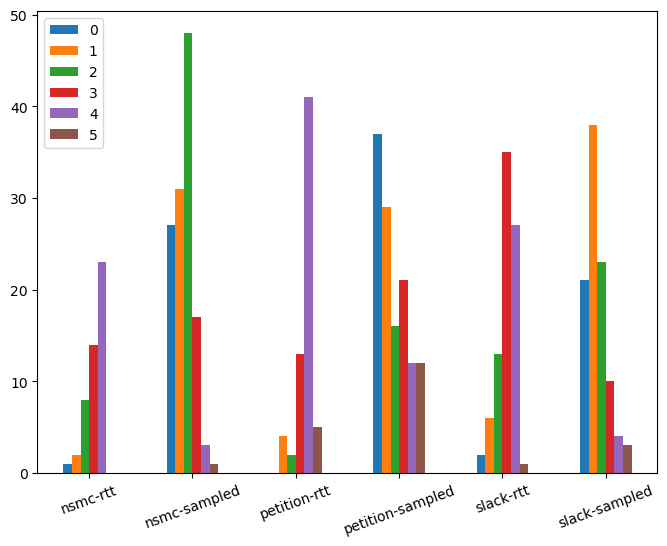

In [40]:
# val data에 대해서도 동일하게 해보기

source_label = {source:[0, 0, 0, 0, 0, 0] for source in sorted(val_data['source'].unique())}  

for i, item in val_data.iterrows():
    label_value = int(item['label'])
    if   label_value == 0:  col = 0
    elif label_value < 2.0: col = 1
    elif label_value < 3.0: col = 2
    elif label_value < 4.0: col = 3
    elif label_value < 5.0: col = 4
    else:                   col = 5
        
    source_label[item['source']][col] += 1

source_label_df = pd.DataFrame(source_label).transpose()
source_label_df.plot(kind='bar', rot=20, figsize=(8, 6))